In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

Estimating the CAPM

In [3]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

Here we choose Apple as the risky asset, and S&P 500 index as the proxy of market portfolio.

In [4]:
RISKY_ASSET = "AAPL"
MARKET_BENCHMARK = "^GSPC"
START_DATE = "2016-01-01"
END_DATE = "2024-12-31"

In [5]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 auto_adjust = False, 
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 2068 rows of data.


The data we download from Yahoo Finance is daily data.  
<br>
<br>
Next, we will convert it to monthly data and caluclate monthly returns.
<br>
Specifically, we keep the last observation of each month and calculate the simple returns.

In [6]:
X = (
    df["Adj Close"]
    .rename(columns={RISKY_ASSET: "asset", 
                     MARKET_BENCHMARK: "market"})
    .resample("M")
    .last()
    .pct_change()
    .dropna()
)
X.head()

,asset,market
Date,,
2016-02-29,-0.001287,-0.004128
2016-03-31,0.127211,0.065991
2016-04-30,-0.139921,0.002699
2016-05-31,0.071773,0.015325
2016-06-30,-0.042660,0.000911


We can simply calculate the beta from covariance and variance of the risky asset and market portfolio.

In [7]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.226581787461964

We can also regress the returns of risky asset on the returns of market portfolio. 
<br>
The slope of the regression is beta.

In [8]:
# separate target
y = X.pop("asset")

# add constant
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     79.50
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           3.17e-14
Time:                        13:27:23   Log-Likelihood:                 134.64
No. Observations:                  98   AIC:                            -265.3
Df Residuals:                      96   BIC:                            -260.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.006      1.662      0.1

Also, we can use the formula notation to achive the same results above.

In [9]:
import statsmodels.formula.api as smf

# rerun step 4 to have a DF with columns: `asset` and `market`
X = df["Adj Close"].rename(columns={RISKY_ASSET: "asset", 
                                    MARKET_BENCHMARK: "market"}) \
                   .resample("M") \
                   .last() \
                   .pct_change() \
                   .dropna()

# define and fit the regression model 
capm_model = smf.ols(formula="asset ~ market", data=X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     79.50
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           3.17e-14
Time:                        13:27:26   Log-Likelihood:                 134.64
No. Observations:                  98   AIC:                            -265.3
Df Residuals:                      96   BIC:                            -260.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0107      0.006      1.662      0.1

In reality, instead of using all historical data to estimate beta, we use rolling-window to update the beta every month.  The window are typically 5 years.

In [10]:
def rolling_factor_model(input_data, formula, window_size):
    """
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    """

    coeffs = []

    for start_ind in range(len(input_data) - window_size + 1):        
        end_ind = start_ind + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_ind:end_ind]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

Estimate the rolling CAPM model and plot the results:

In [11]:
MODEL_FORMULA = "asset ~ market"
results_df = rolling_factor_model(X, 
                                  MODEL_FORMULA, 
                                  window_size=60)

# Print the last 10 beta estimation.
results_df.iloc[-10:]


,Intercept,market
Date,,
2023-06-30,0.016662,1.286972
2023-07-31,0.016514,1.286853
2023-08-31,0.013606,1.274470
2023-09-30,0.013295,1.286786
2023-10-31,0.012581,1.305289
2023-11-30,0.015917,1.308198
2023-12-31,0.015357,1.289008
2024-01-31,0.014825,1.312121
2024-02-29,0.013561,1.288498


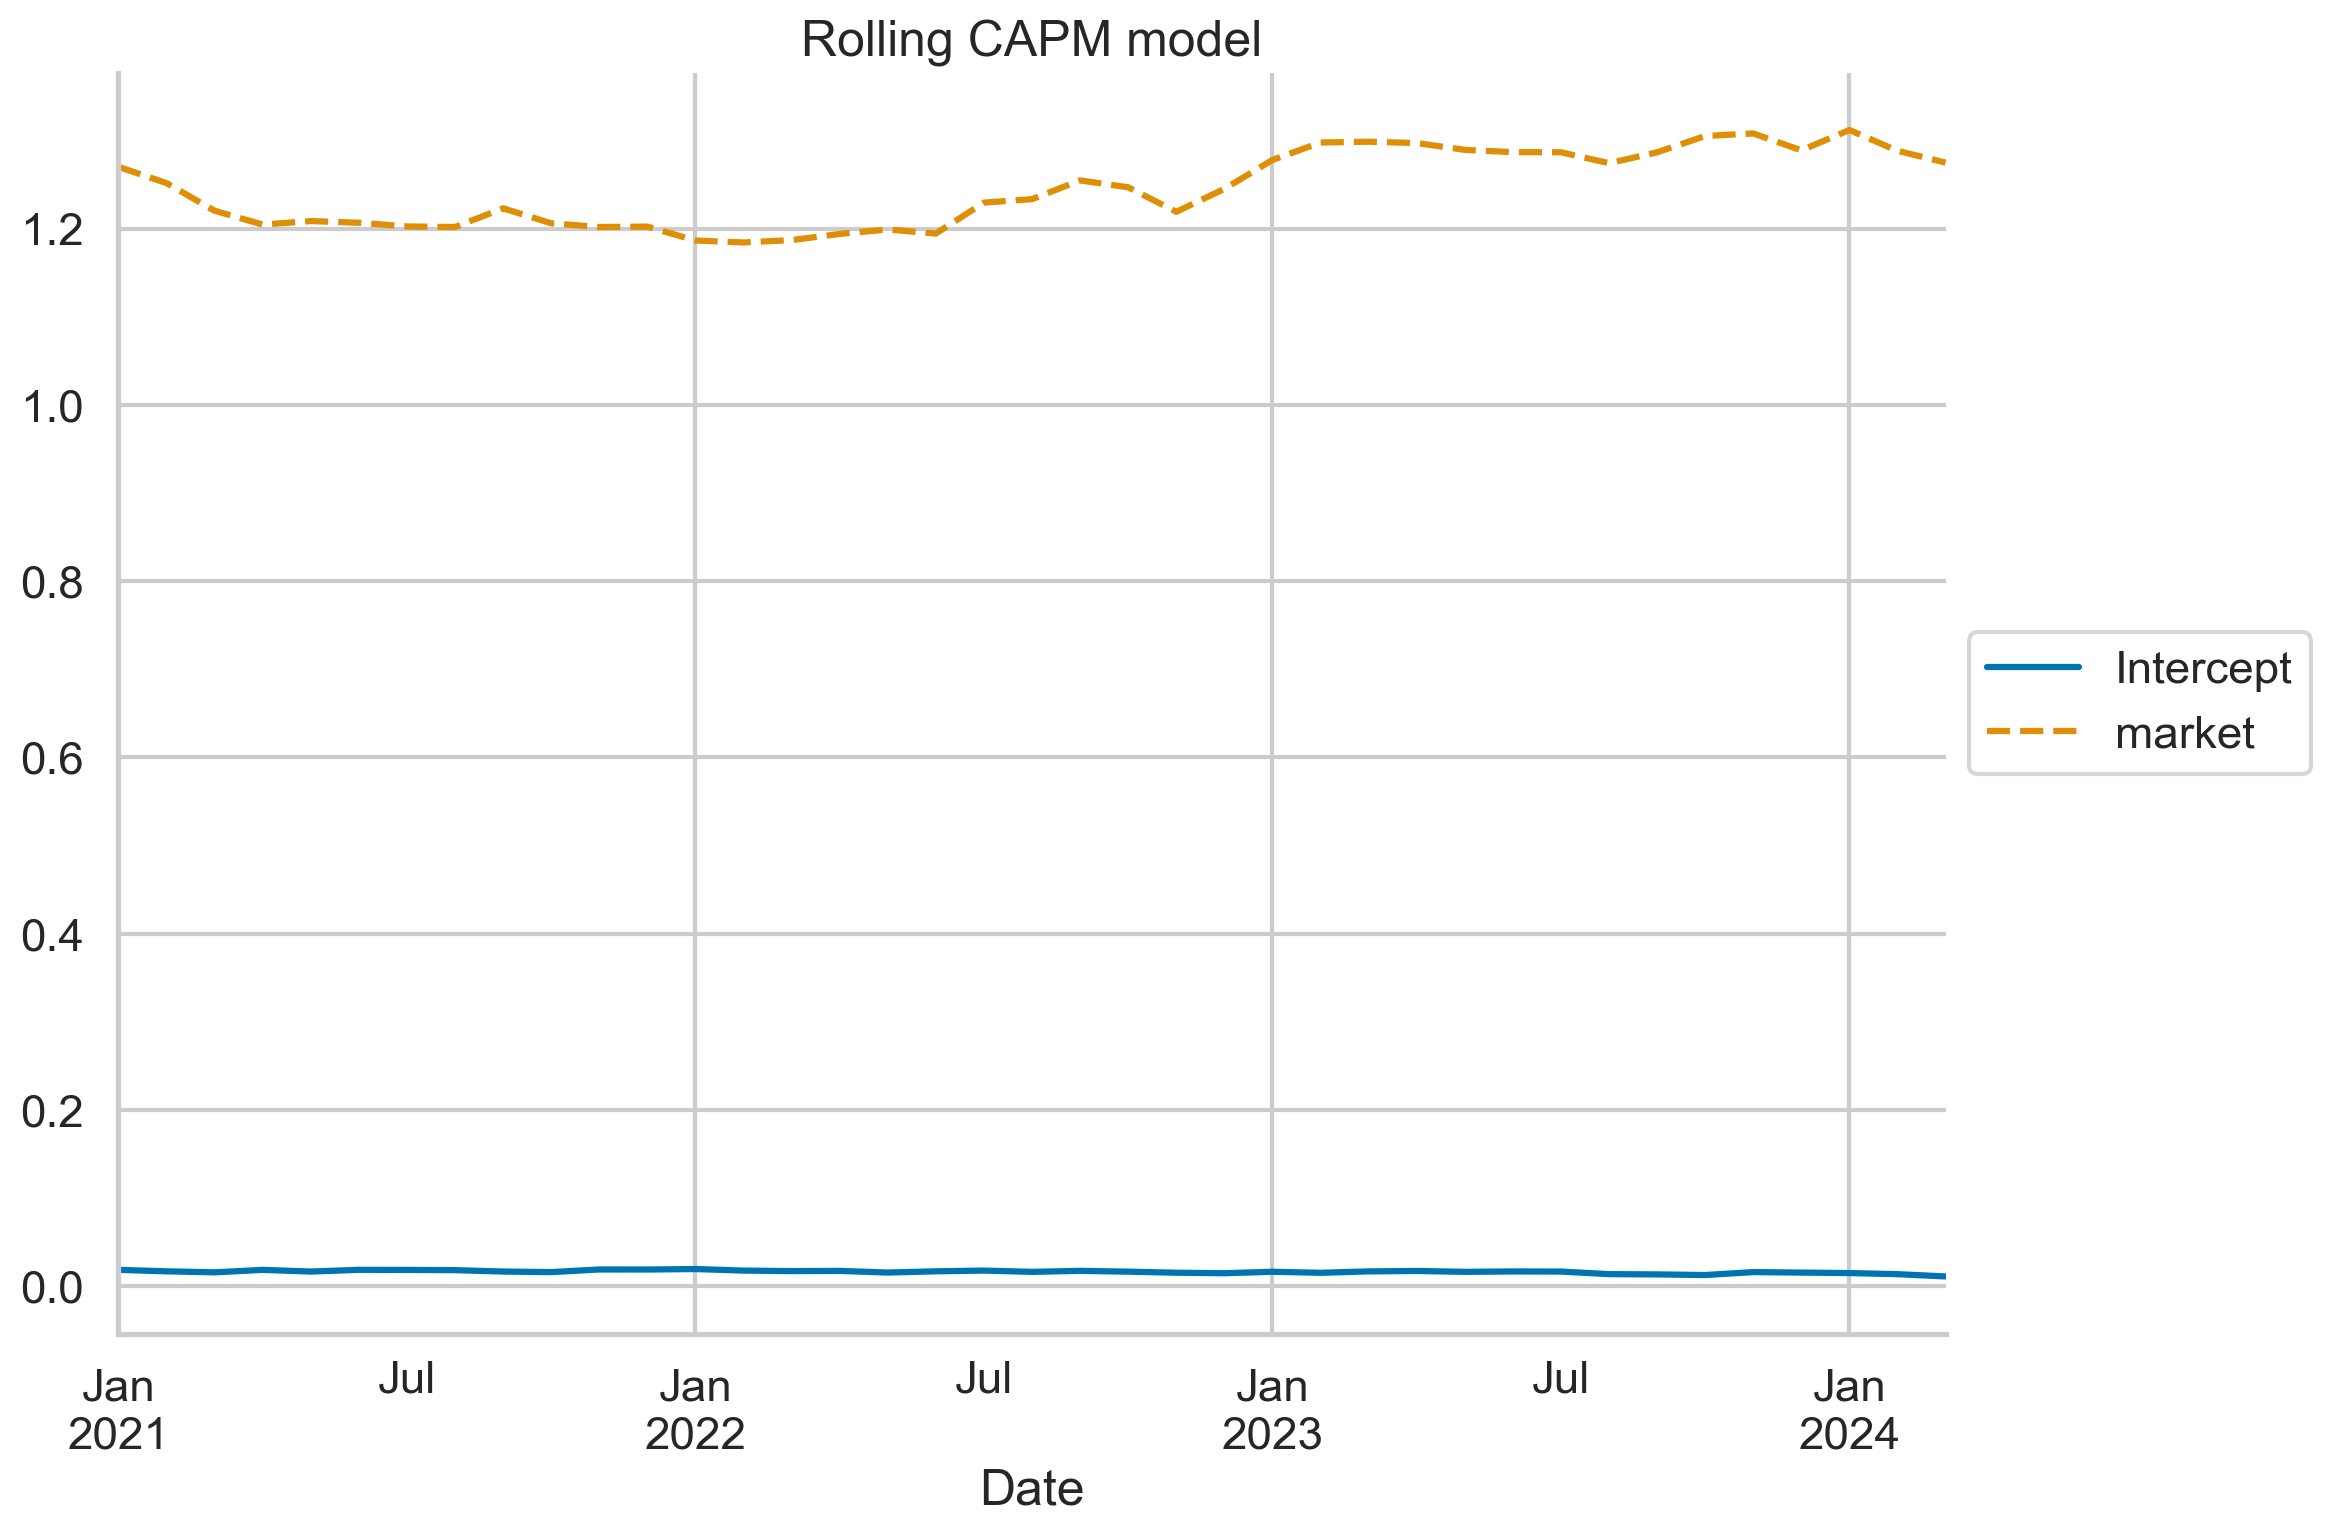

In [12]:
(

    results_df
    .plot(title = "Rolling CAPM model",
          style=["-", "--", "-.", ":"])
    .legend(loc="center left",bbox_to_anchor=(1.0, 0.5))
)


sns.despine()
plt.tight_layout()

The results above assume the risk-free rates are zero.
<br>
<br>
It is a fair assumption in the past ten years.

Let's take a look at the risk-free rate today.

In [13]:
# period length in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download("^IRX",
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample("M").last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

rf[-10:]

# # plot the risk-free rate
# rf.plot(title="Risk-free rate (13 Week Treasury Bill)")

# sns.despine()
# plt.tight_layout()

Date
2023-06-30    0.004331
2023-07-31    0.004412
2023-08-31    0.004454
2023-09-30    0.004456
2023-10-31    0.004473
2023-11-30    0.004403
2023-12-31    0.004354
2024-01-31    0.004361
2024-02-29    0.004391
2024-03-31    0.004395
Freq: ME, Name: Close, dtype: float64

In [14]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader(
    "TB3MS", "fred", start=START_DATE, end=END_DATE
)

# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1

rf[-10:]

# # plot the risk-free rate
# rf.plot(title="Risk-free rate (3-Month Treasury Bill)")

# sns.despine()
# plt.tight_layout()

,TB3MS
DATE,
2023-05-01,0.004186
2023-06-01,0.004202
2023-07-01,0.004273
2023-08-01,0.004313
2023-09-01,0.004329
2023-10-01,0.004345
2023-11-01,0.004289
2023-12-01,0.004265
2024-01-01,0.004249


Clearly, the risk-free rate is no longer zero recently.
<br>
<br>
So let's estimate the "correct" beta now.

In [15]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

In [16]:
RISKY_ASSET = "AAPL"
MARKET_BENCHMARK = "^GSPC"
START_DATE = "2016-01-01"
END_DATE = "2024-12-31"

In [17]:
X = (
    df["Adj Close"]
    .rename(columns={RISKY_ASSET: "asset", 
                     MARKET_BENCHMARK: "market"})
    .resample("M")
    .last()
    .pct_change()
    .dropna()
)
X.head()

,asset,market
Date,,
2016-02-29,-0.001287,-0.004128
2016-03-31,0.127211,0.065991
2016-04-30,-0.139921,0.002699
2016-05-31,0.071773,0.015325
2016-06-30,-0.042660,0.000911


In [18]:
# period length in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download("^IRX",
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample("M").last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

# rf = rf.rename(columns={"Close":"mean"})

rf.head()

Date
2016-01-31    0.000250
2016-02-29    0.000257
2016-03-31    0.000161
2016-04-30    0.000161
2016-05-31    0.000236
Freq: ME, Name: Close, dtype: float64

In [19]:
X = X.join(rf)
X = X.rename(columns={"Close":"rf"})


X["excess_rtn"] = (
    X["asset"] - X["rf"]
)

X["mkt_prm"] = (
    X["market"] - X["rf"]
)

X.head()

,asset,market,rf,excess_rtn,mkt_prm
Date,,,,,
2016-02-29,-0.001287,-0.004128,0.000257,-0.001544,-0.004385
2016-03-31,0.127211,0.065991,0.000161,0.127050,0.065830
2016-04-30,-0.139921,0.002699,0.000161,-0.140082,0.002539
2016-05-31,0.071773,0.015325,0.000236,0.071537,0.015089
2016-06-30,-0.042660,0.000911,0.000207,-0.042867,0.000704


In [20]:
MODEL_FORMULA = "excess_rtn ~ mkt_prm"
results_df = rolling_factor_model(X, 
                                  MODEL_FORMULA, 
                                  window_size=60)

# Print the last 10 beta estimation.
results_df.iloc[-10:]

,Intercept,mkt_prm
Date,,
2023-06-30,0.017036,1.287943
2023-07-31,0.016895,1.288618
2023-08-31,0.013979,1.276960
2023-09-30,0.013698,1.289533
2023-10-31,0.013024,1.307818
2023-11-30,0.016374,1.310796
2023-12-31,0.015776,1.292941
2024-01-31,0.015286,1.317295
2024-02-29,0.013975,1.295447


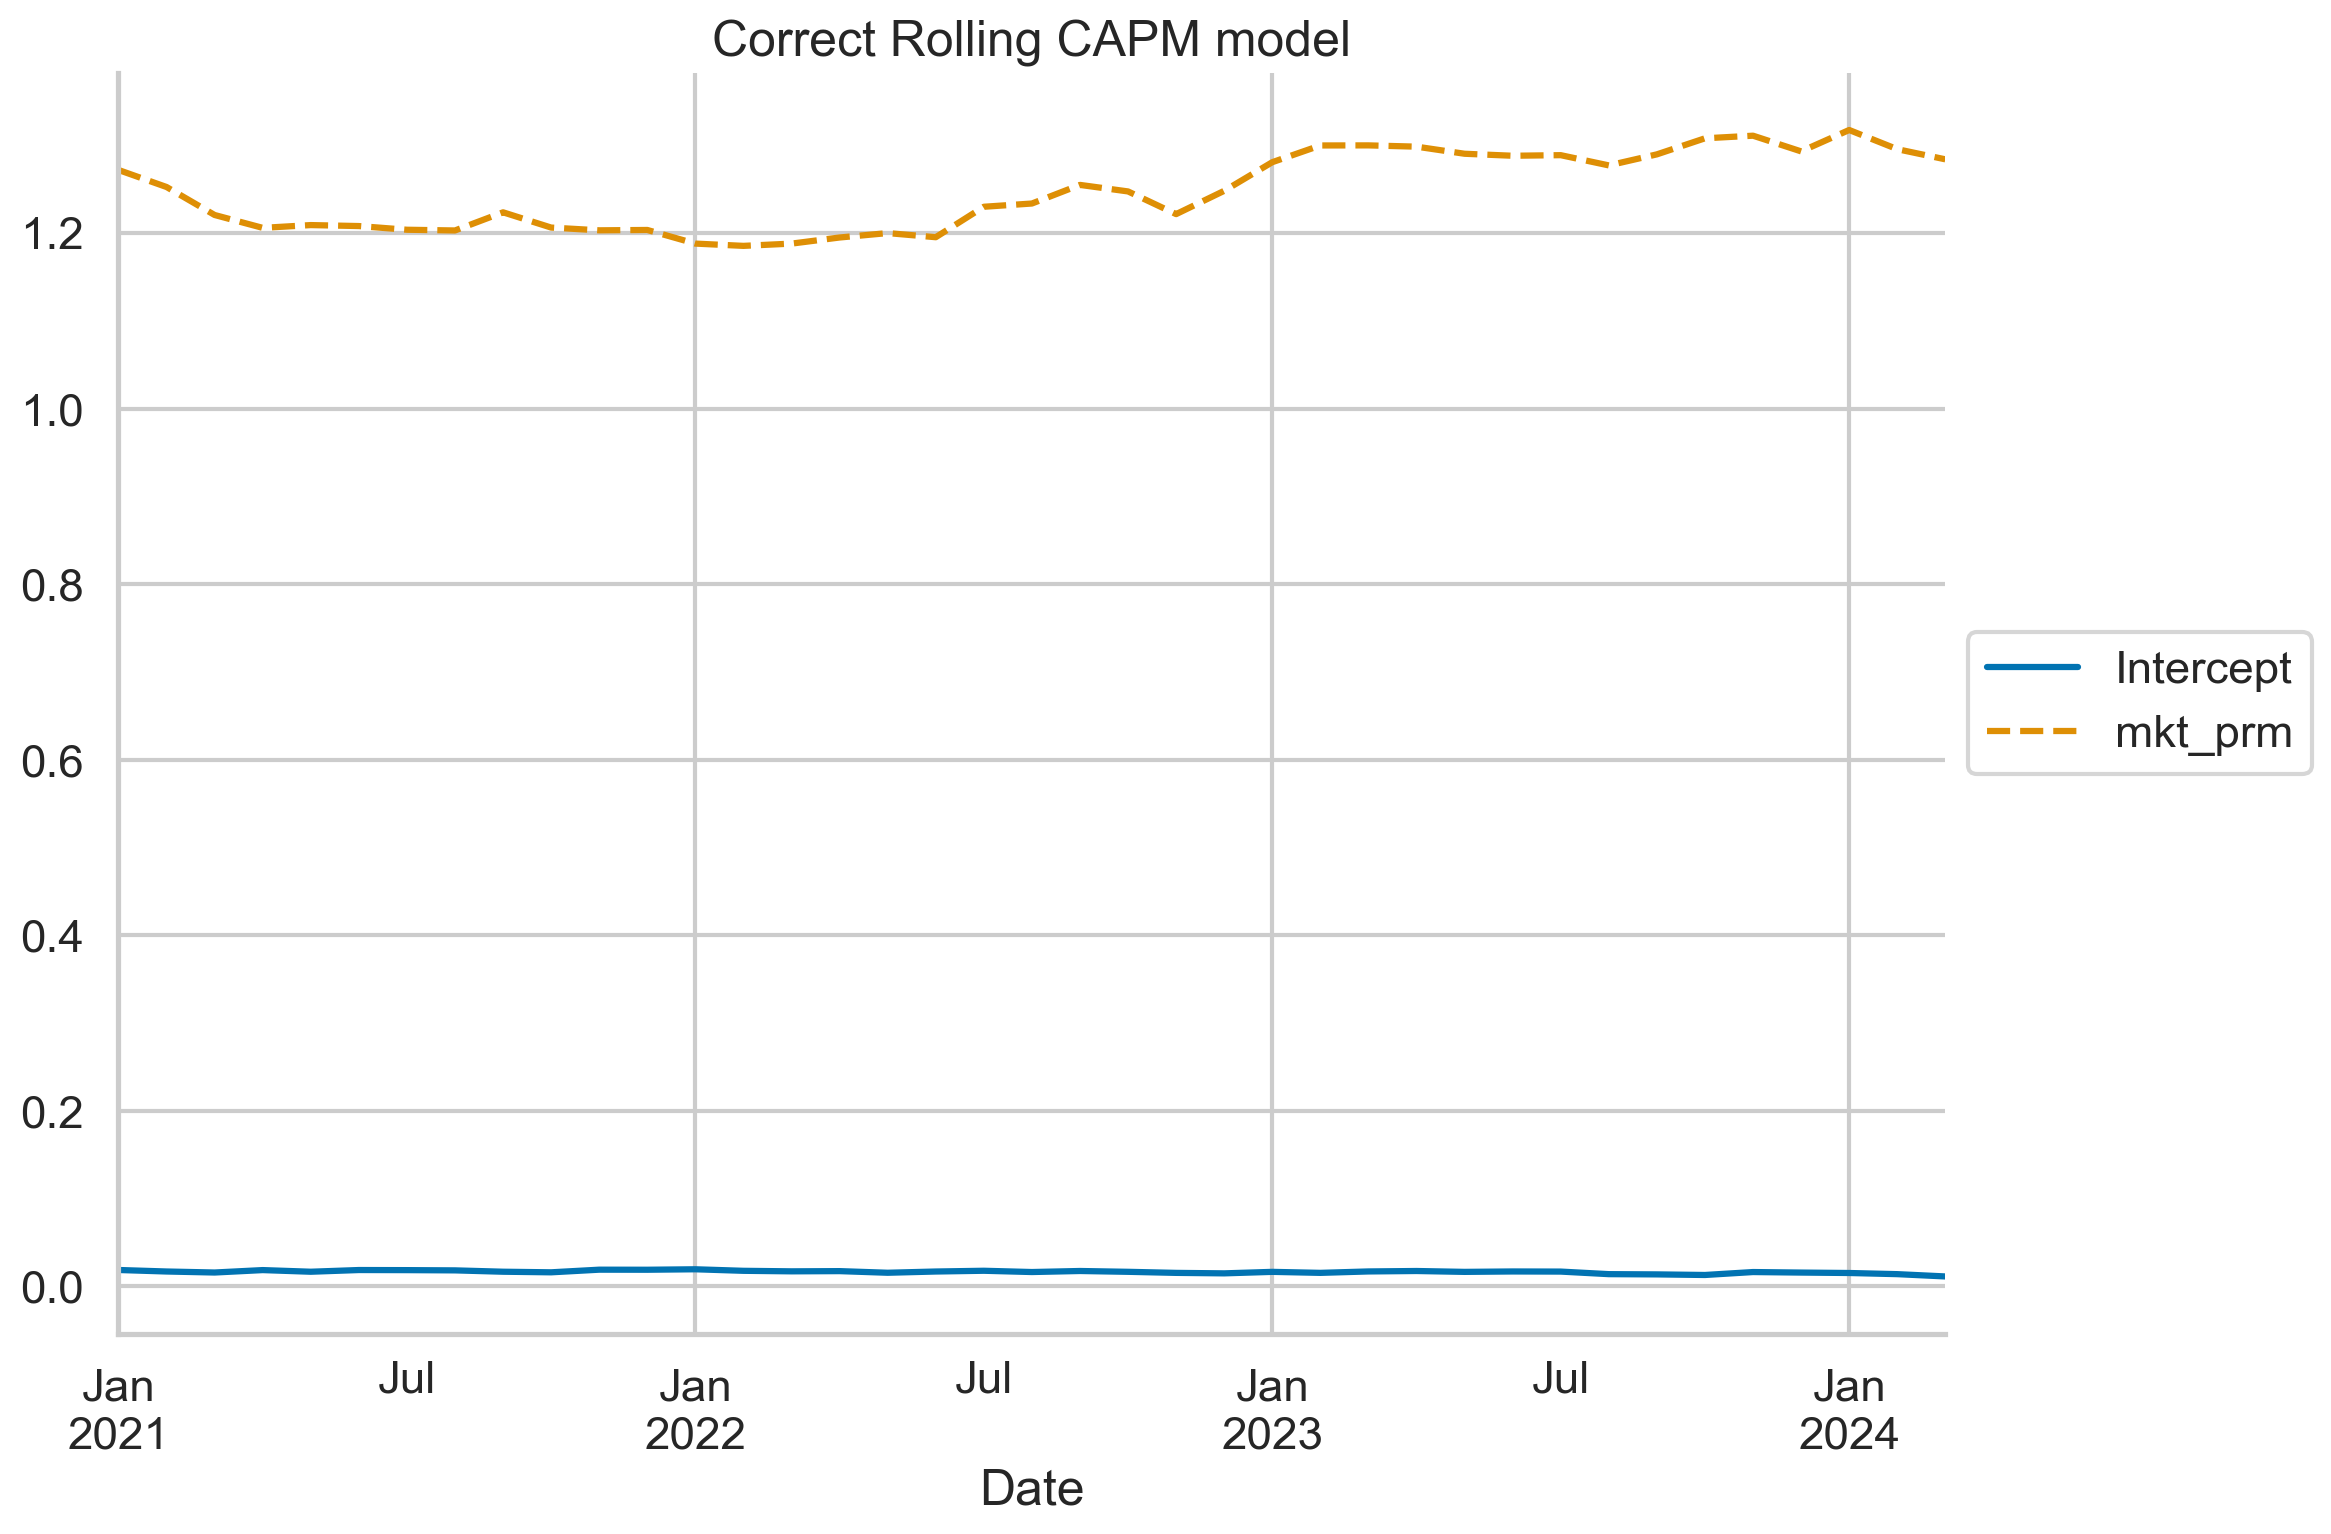

In [21]:
(

    results_df
    .plot(title = "Correct Rolling CAPM model",
          style=["-", "--", "-.", ":"])
    .legend(loc="center left",bbox_to_anchor=(1.0, 0.5))
)


sns.despine()
plt.tight_layout()

Estimating the Fama-French three-factor model
<br>
<br>
1. MKT is the excess return of the market. It is the return on the value-weighted market portfolio.
<br>
2. SMB is the return on a diversified portfolio of small-cap stocks minus the return on a diversified portfolio of big-cap stocks.
<br>
3. HML is the difference between the returns on diversified portfolios of stocks with high and low Book-to-Market ratios.

In [22]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

In [23]:
RISKY_ASSET = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2024-12-31"

Download the dataset of the Fama-French risk factors:

In [24]:
ff_dict = web.DataReader("F-F_Research_Data_Factors", 
                         "famafrench", 
                         start=START_DATE,
                         end=END_DATE)

In [25]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [26]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202401 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2024 Kenneth R. French

  0 : (97 rows x 4 cols)
  1 : Annual Factors: January-December (8 rows x 4 cols)


In [27]:
factor_3_df = ff_dict[0]

factor_3_df.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2016-01,-5.77,-3.42,2.09,0.01
2016-02,-0.07,0.73,-0.57,0.02
2016-03,6.96,0.82,1.19,0.02
2016-04,0.91,0.76,3.28,0.01
2016-05,1.78,-0.17,-1.66,0.01


The column "Mkt - RF" is the returns of market portfolio minus risk-free rate.  So it is already the market risk premium.  We just need to change its name for convience.

The data we download are percentage points.  We need to divide 100 to convert them as percentage.

In [28]:
factor_3_df = ff_dict[0].rename(columns={"Mkt-RF": "MKT"}) \
                        .div(100)

factor_3_df.head()

,MKT,SMB,HML,RF
Date,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001
2016-02,-0.0007,0.0073,-0.0057,0.0002
2016-03,0.0696,0.0082,0.0119,0.0002
2016-04,0.0091,0.0076,0.0328,0.0001
2016-05,0.0178,-0.0017,-0.0166,0.0001


In [29]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       auto_adjust = False, 
                       progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 2068 rows of data.


Now we generate the monthly returns from the prices of the risky asset:

In [30]:
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.to_period("m")
y.name = "rtn"
y.head()

Date
2016-02   -0.001288
2016-03    0.127211
2016-04   -0.139921
2016-05    0.071773
2016-06   -0.042660
Freq: M, Name: rtn, dtype: float64

Merge the datasets 

In [31]:
factor_3_df = factor_3_df.join(y)

Calculate excess returns, which is returns from risky assets minus risk-free rates.

In [32]:
factor_3_df["excess_rtn"] = (
    factor_3_df["rtn"] - factor_3_df["RF"]
)
factor_3_df.head()

,MKT,SMB,HML,RF,rtn,excess_rtn
Date,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,NaN,NaN
2016-02,-0.0007,0.0073,-0.0057,0.0002,-0.001288,-0.001488
2016-03,0.0696,0.0082,0.0119,0.0002,0.127211,0.127011
2016-04,0.0091,0.0076,0.0328,0.0001,-0.139921,-0.140021
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.071773,0.071673


Estimate the three-factor model:

In [33]:
ff3_model = smf.ols(formula="excess_rtn ~ MKT + SMB + HML", 
                   data=factor_3_df).fit()

# print results 
print(ff3_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     38.66
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           2.95e-16
Time:                        13:29:08   Log-Likelihood:                 141.51
No. Observations:                  96   AIC:                            -275.0
Df Residuals:                      92   BIC:                            -264.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0098      0.006      1.652      0.1

<br>

Try it yourself, please estimate the rolling FF 3 factor model with 5-year window.

,Intercept,MKT,SMB,HML
Date,,,,
2023-04,0.014771,1.302543,-0.279272,-0.503204
2023-05,0.012959,1.311933,-0.387292,-0.479603
2023-06,0.013573,1.308353,-0.375255,-0.485311
2023-07,0.013711,1.315446,-0.405142,-0.490150
2023-08,0.010995,1.304989,-0.405012,-0.449989
2023-09,0.010869,1.317186,-0.411594,-0.460023
2023-10,0.010017,1.334646,-0.376884,-0.476220
2023-11,0.013319,1.343175,-0.406139,-0.470414
2023-12,0.013468,1.331530,-0.433800,-0.479354


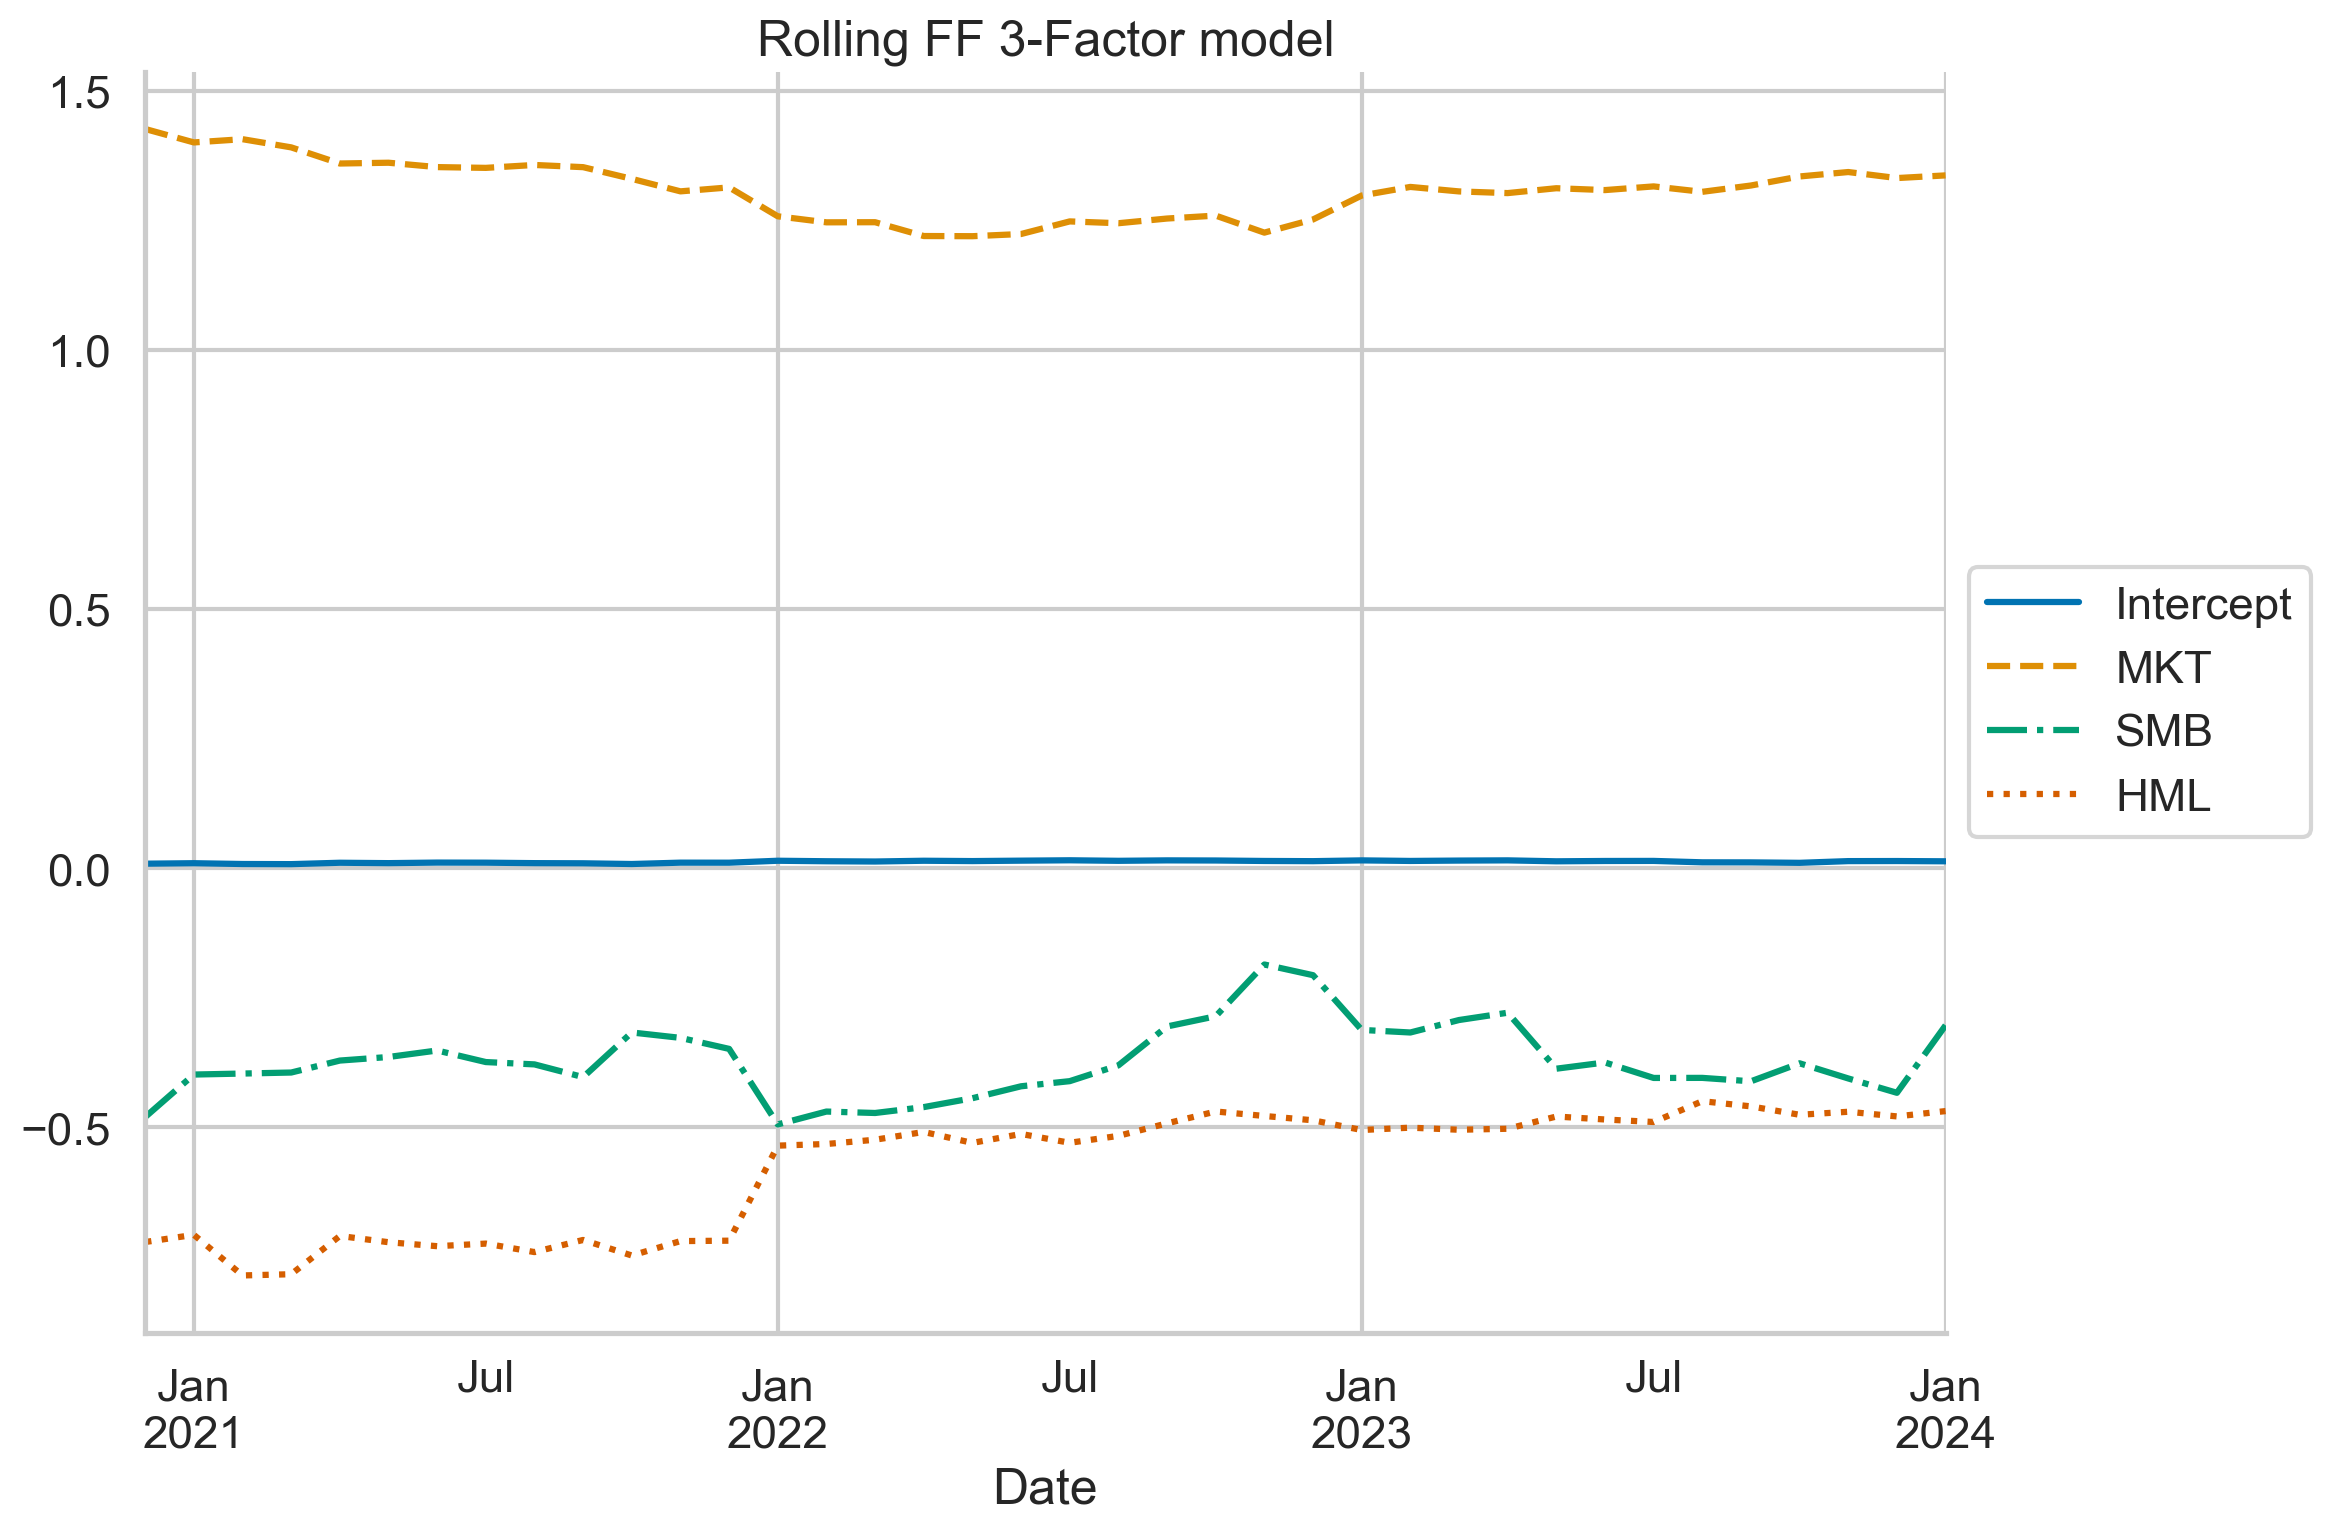

<br>

There are more datasets available for downloading.

In [36]:
from pandas_datareader.famafrench import get_available_datasets

get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

<br>

Carhart four-factor model:
<br>
<br>
1. MOM (aka UMD) is the excess return of positive over negative momentum stocks.

Fama French five-factor model:
<br>
<br>
1. RMW is the difference between the returns on diversified portfolios of stocks with robust (high and steady) and weak (low) profitability.
<br>
2. CMA is the difference between the returns on diversified portfolios of the stocks of low and high investment firms, which we call conservative and aggressive. Here, low/high investment means reinvestment ratio is low/high.

In [37]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

In [38]:
RISKY_ASSET = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2024-12-31"

Download the risk factors from prof. French's website:

In [39]:
# three factors 
factor_3_df = web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

# momentum factor
momentum_df = web.DataReader("F-F_Momentum_Factor", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]
      
# five factors
factor_5_df = web.DataReader("F-F_Research_Data_5_Factors_2x3", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]

In [40]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       auto_adjust = False, 
                       progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 2068 rows of data.


In [41]:
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.to_period("m")
y.name = "rtn"

Merge the datasets for the four-factor models:

In [42]:
# join all datasets on the index
factor_4_df = factor_3_df.join(momentum_df).join(y)

# rename columns
factor_4_df.columns = ["mkt", "smb", "hml", "rf", "mom", "rtn"]

# divide everything (except returns) by 100
factor_4_df.loc[:, factor_4_df.columns != "rtn"] /= 100

# calculate excess returns
factor_4_df["excess_rtn"] = (
    factor_4_df["rtn"] - factor_4_df["rf"]
)

factor_4_df.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
Date,,,,,,,
2016-01,-0.0577,-0.0342,0.0209,0.0001,0.0144,NaN,NaN
2016-02,-0.0007,0.0073,-0.0057,0.0002,-0.0438,-0.001287,-0.001487
2016-03,0.0696,0.0082,0.0119,0.0002,-0.0501,0.127211,0.127011
2016-04,0.0091,0.0076,0.0328,0.0001,-0.0602,-0.139921,-0.140021
2016-05,0.0178,-0.0017,-0.0166,0.0001,0.0142,0.071773,0.071673


Estimate the four-factor model:

In [43]:
four_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + mom", 
    data=factor_4_df
).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     29.39
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           1.09e-15
Time:                        13:29:33   Log-Likelihood:                 142.17
No. Observations:                  96   AIC:                            -274.3
Df Residuals:                      91   BIC:                            -261.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0095      0.006      1.590      0.1

Merge the datasets for the five-factor models:

In [44]:
# join all datasets on the index
factor_5_df = factor_5_df.join(y)

# rename columns
factor_5_df.columns = [
    "mkt", "smb", "hml", "rmw", "cma", "rf", "rtn"
]

# divide everything (except returns) by 100
factor_5_df.loc[:, factor_5_df.columns != "rtn"] /= 100

# calculate excess returns
factor_5_df["excess_rtn"] = (
    factor_5_df["rtn"] - factor_5_df["rf"]
)

factor_5_df.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
Date,,,,,,,,
2016-01,-0.0577,-0.0347,0.0209,0.0282,0.0308,0.0001,NaN,NaN
2016-02,-0.0007,0.0088,-0.0057,0.0325,0.0202,0.0002,-0.001287,-0.001487
2016-03,0.0696,0.0107,0.0119,0.0077,-0.0008,0.0002,0.127211,0.127011
2016-04,0.0091,0.0123,0.0328,-0.0297,0.0190,0.0001,-0.139921,-0.140021
2016-05,0.0178,-0.0061,-0.0166,-0.0109,-0.0248,0.0001,0.071773,0.071673


Estimate the five-factor model:

In [45]:
five_factor_model = smf.ols(
    formula="excess_rtn ~ mkt + smb + hml + rmw + cma", 
    data=factor_5_df
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     23.79
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           3.61e-15
Time:                        13:29:39   Log-Likelihood:                 142.79
No. Observations:                  96   AIC:                            -273.6
Df Residuals:                      90   BIC:                            -258.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0086      0.006      1.421      0.1

<br>

Try it yourself, please estimate the rolling 4- and 5-factor model with 5-year window.

,Intercept,mkt,smb,hml,mom
Date,,,,,
2023-04,0.014282,1.383799,-0.207639,-0.447642,0.242436
2023-05,0.012838,1.375235,-0.315632,-0.439722,0.193023
2023-06,0.013377,1.368794,-0.308624,-0.446720,0.183582
2023-07,0.013533,1.374852,-0.336788,-0.451229,0.181604
2023-08,0.010970,1.333043,-0.371678,-0.433415,0.083842
2023-09,0.010863,1.346163,-0.376564,-0.442170,0.088302
2023-10,0.009883,1.381533,-0.318151,-0.451220,0.135191
2023-11,0.013155,1.370857,-0.366844,-0.454980,0.086786
2023-12,0.013273,1.358441,-0.396608,-0.464679,0.080757


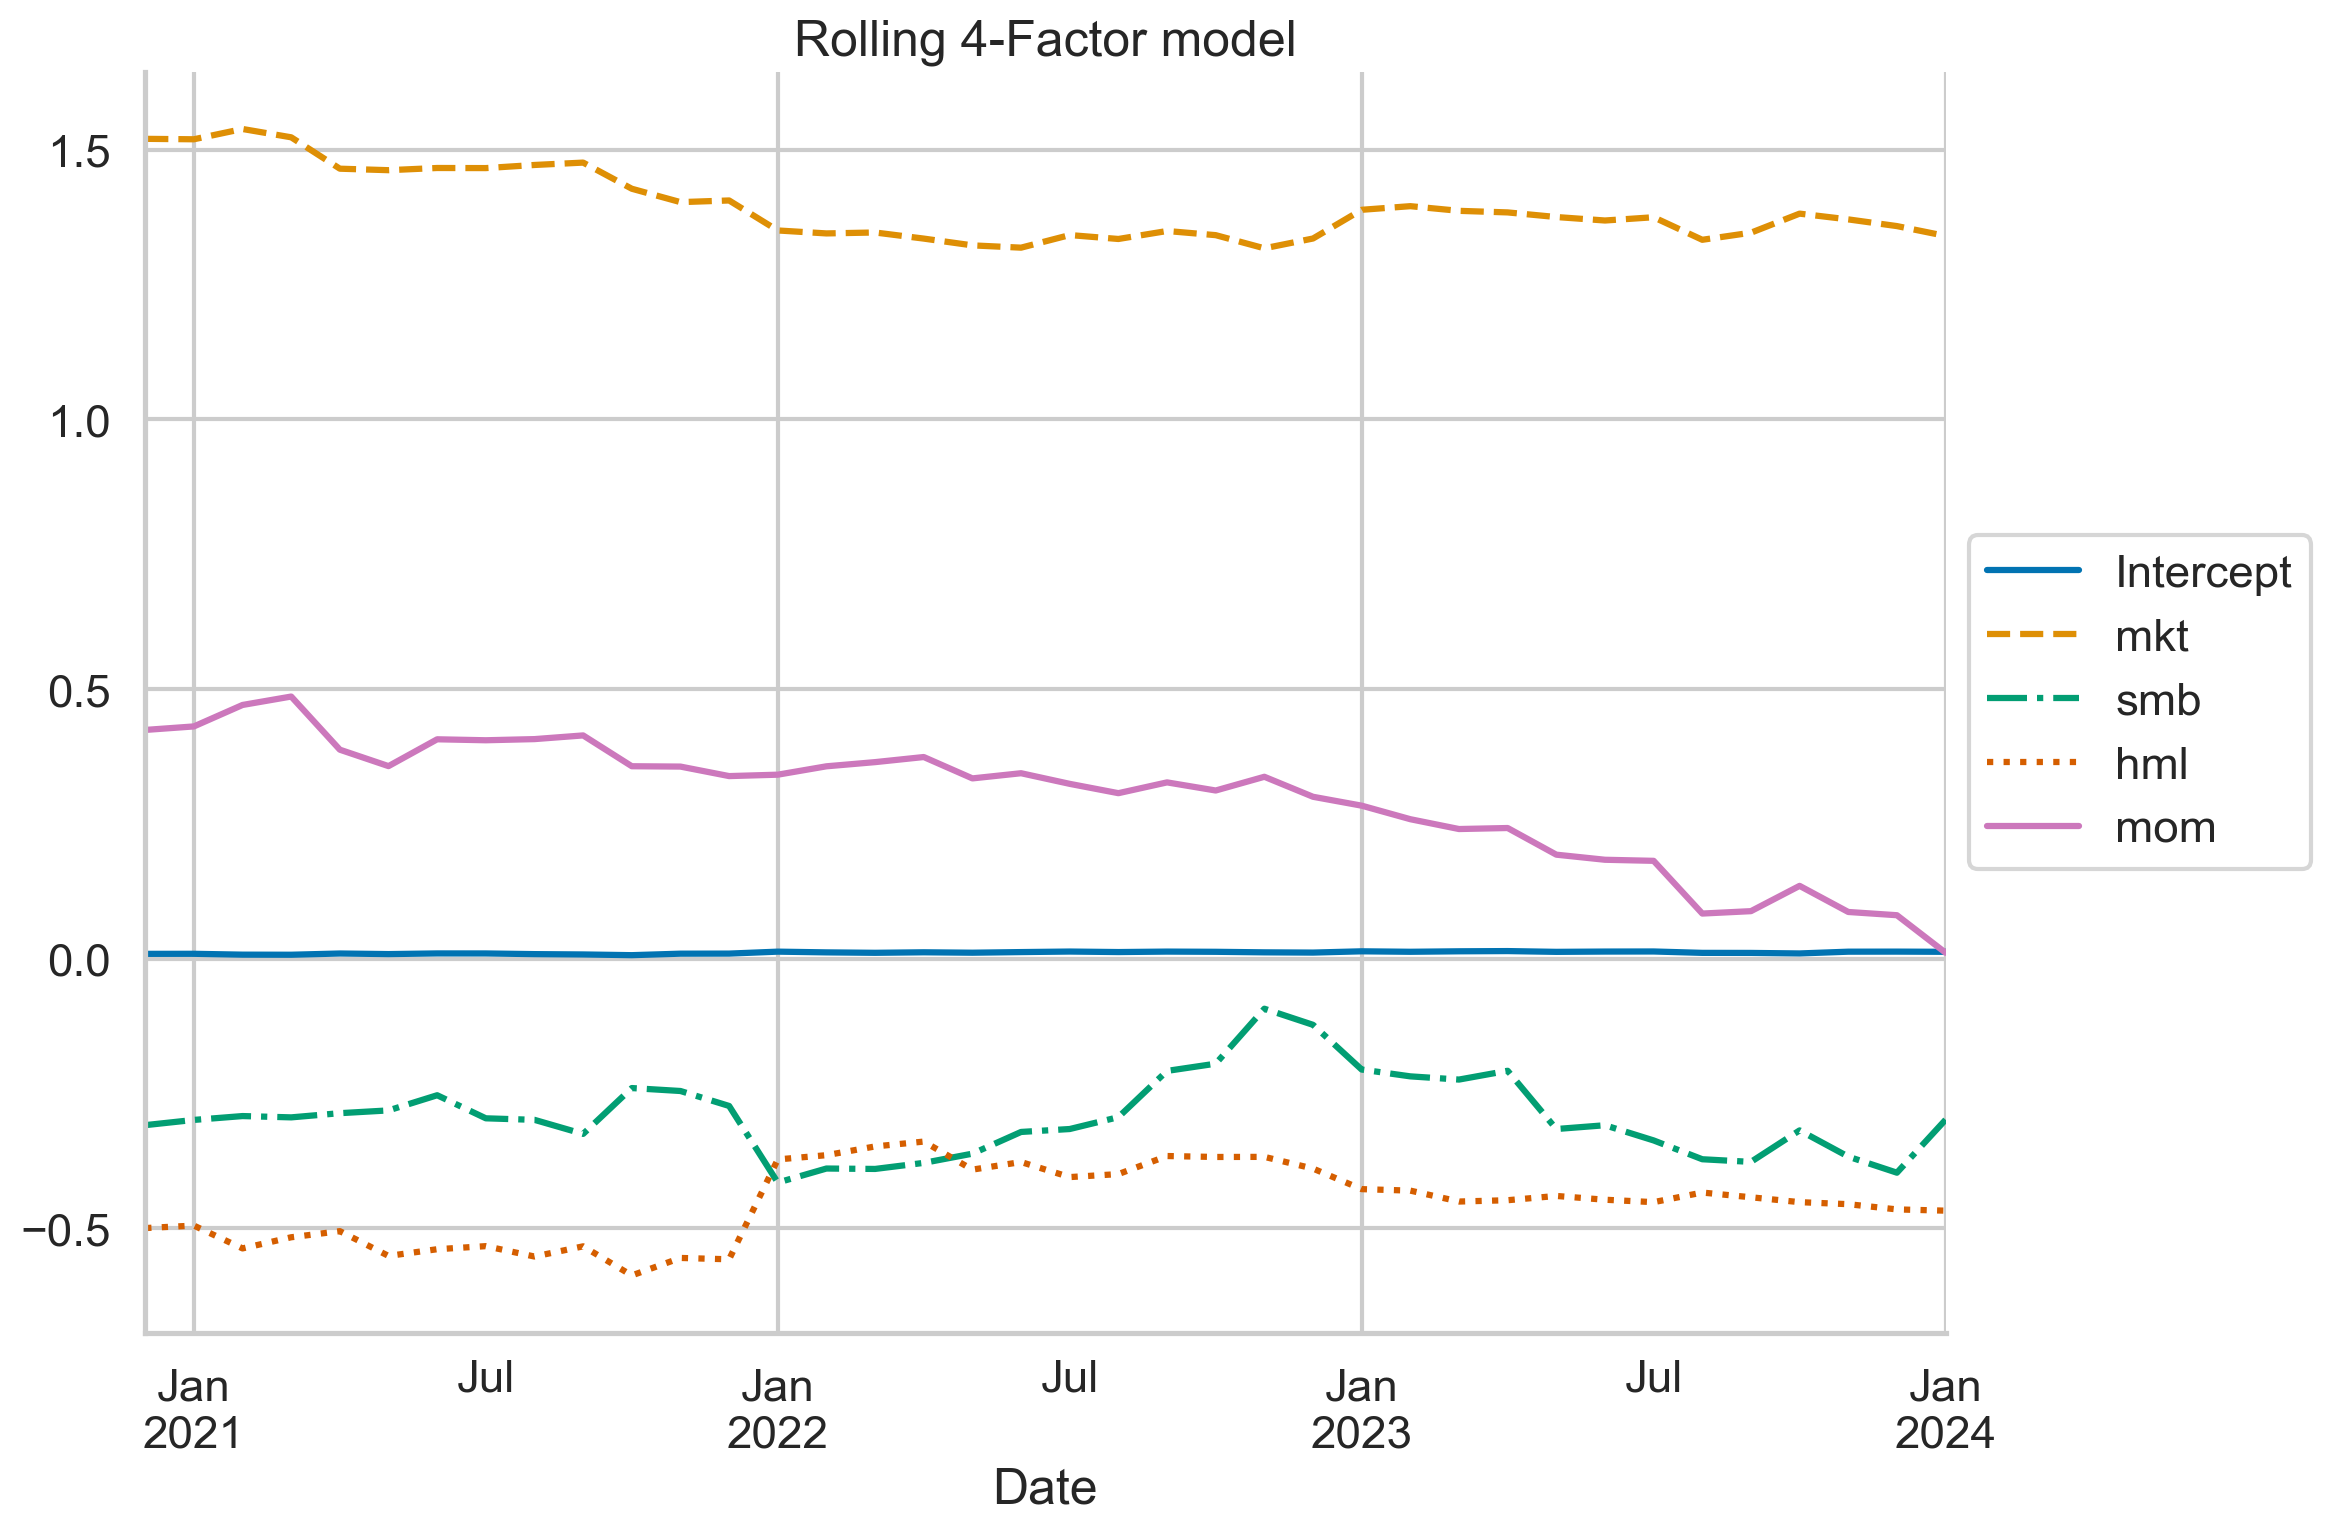

,Intercept,mkt,smb,hml,rmw,cma
Date,,,,,,
2023-04,0.011358,1.315044,-0.157429,-0.652623,0.292453,0.356627
2023-05,0.010017,1.323243,-0.277479,-0.593748,0.283606,0.310435
2023-06,0.010517,1.316852,-0.245912,-0.619622,0.305359,0.334702
2023-07,0.010788,1.324410,-0.271861,-0.615723,0.303566,0.332394
2023-08,0.007762,1.326838,-0.268118,-0.614577,0.282630,0.429636
2023-09,0.007851,1.345510,-0.283680,-0.639645,0.258729,0.480445
2023-10,0.006984,1.353989,-0.236172,-0.662773,0.294182,0.465985
2023-11,0.011192,1.395294,-0.365454,-0.606646,0.129379,0.457419
2023-12,0.011361,1.383932,-0.384135,-0.607178,0.134722,0.449876


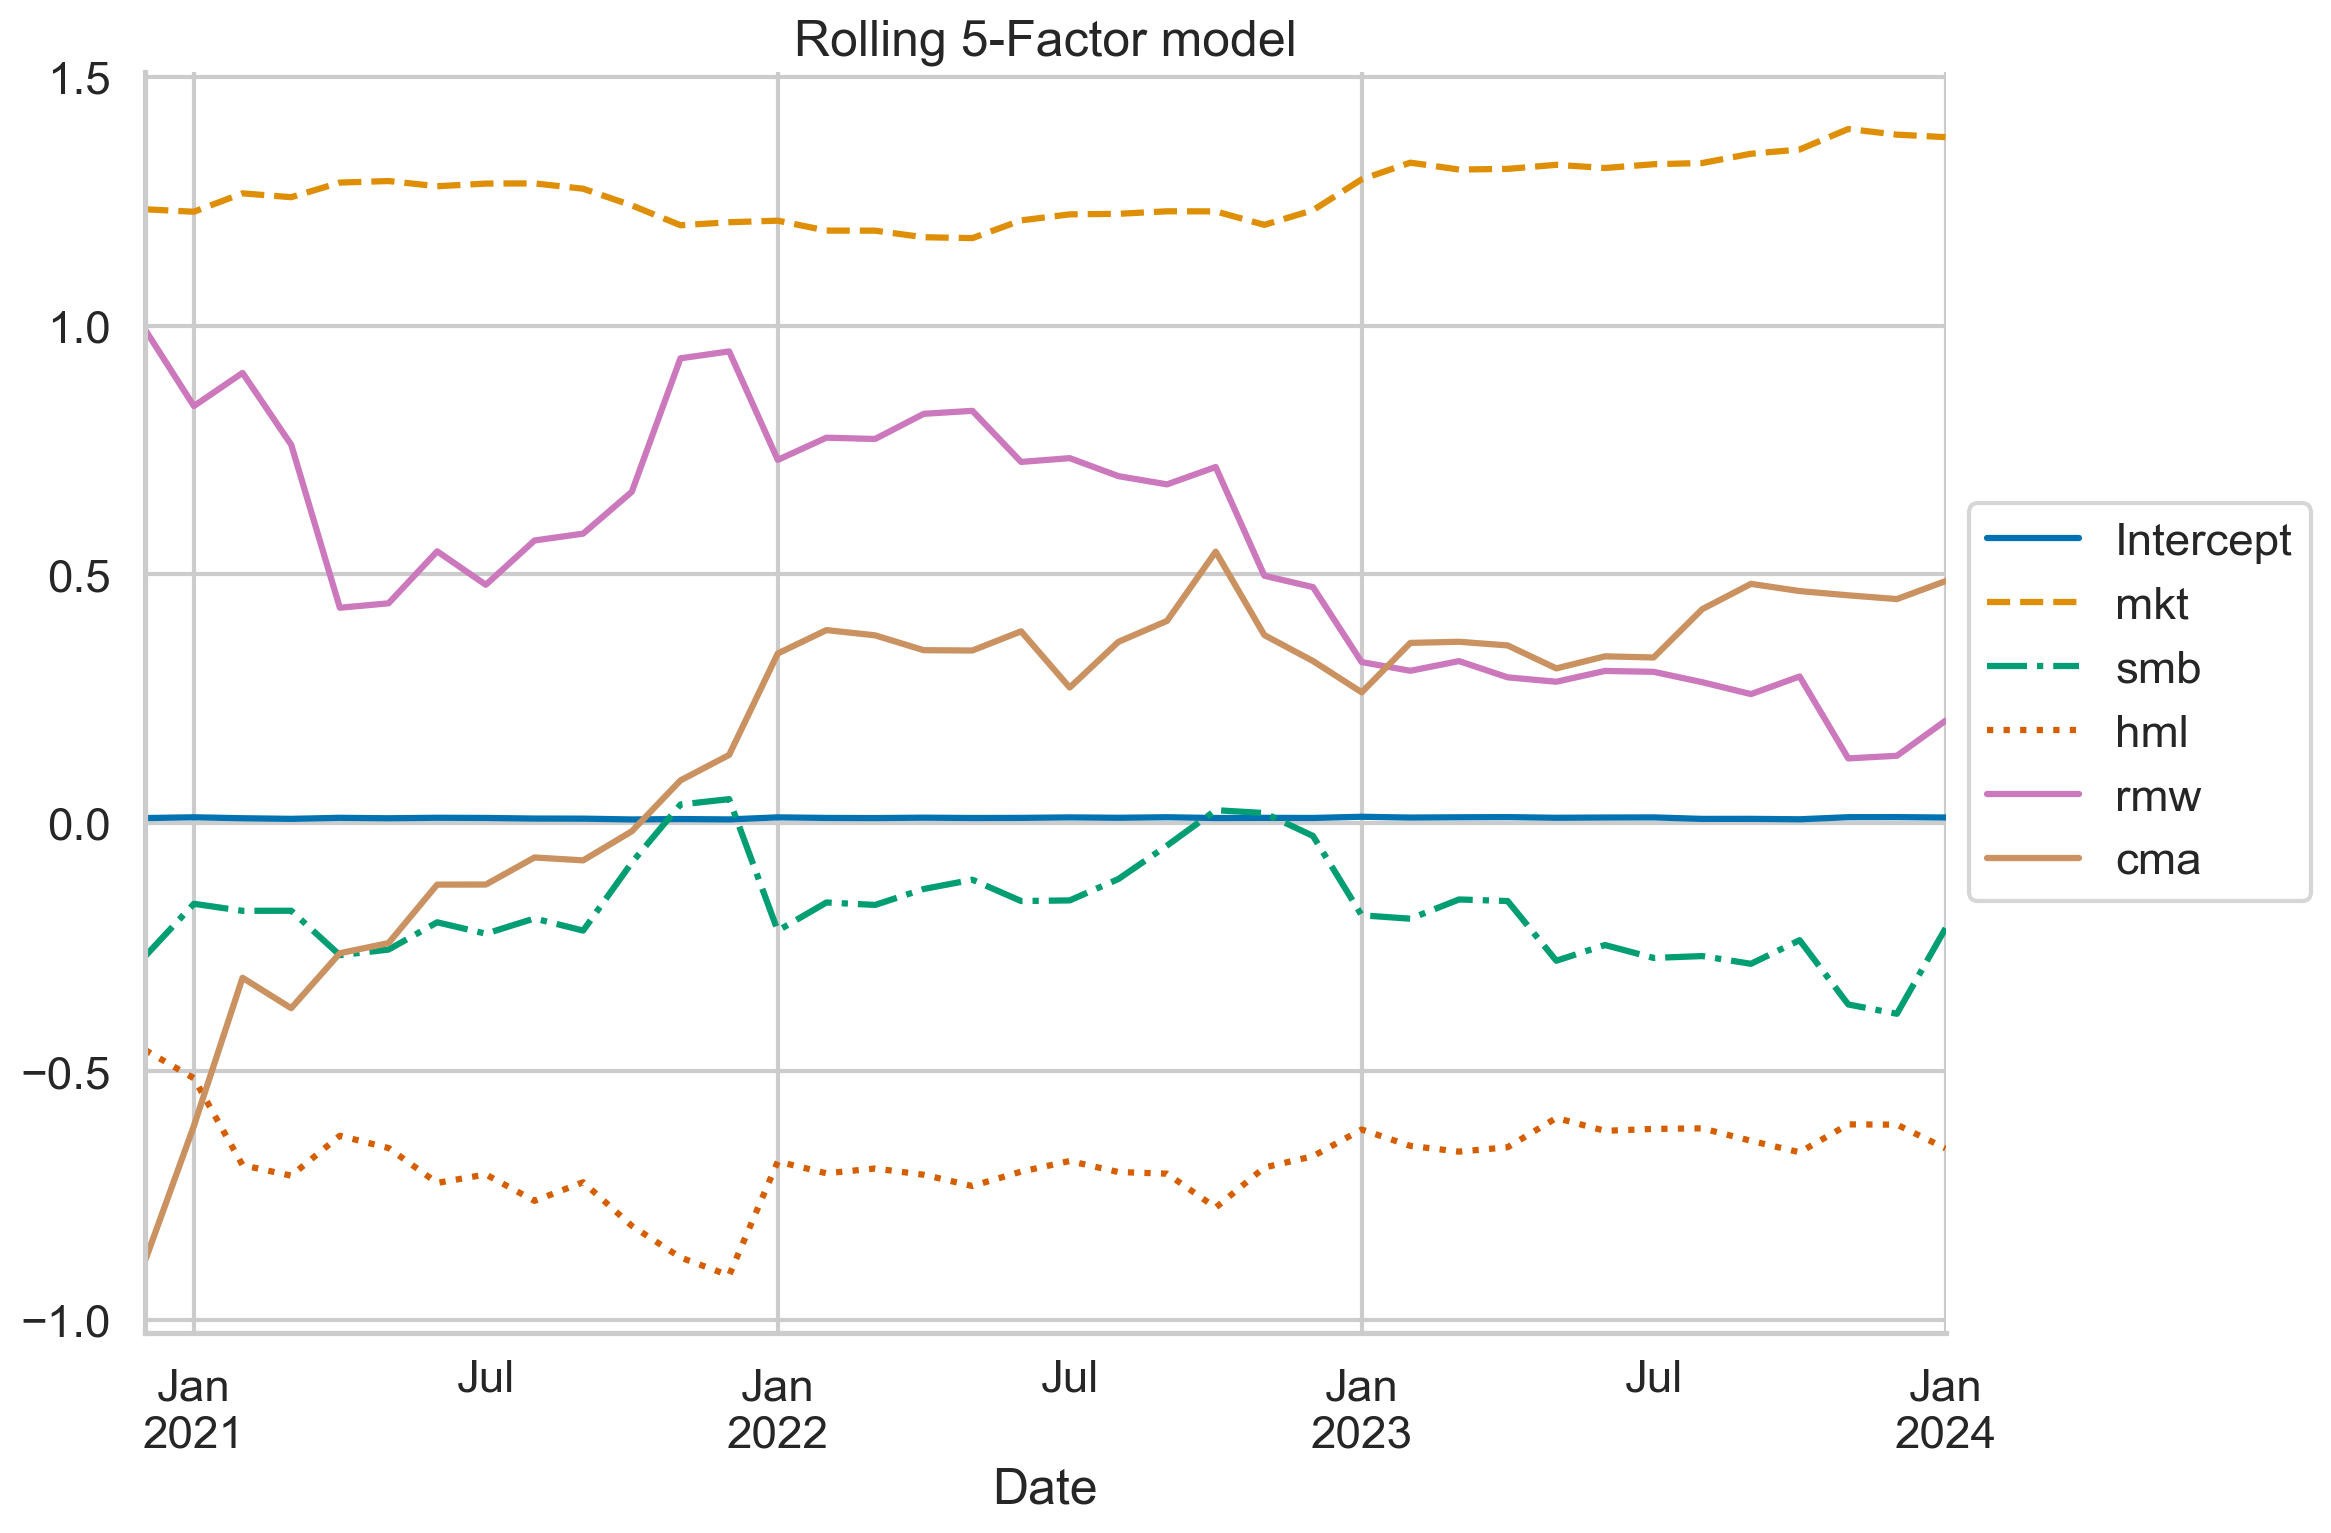

<br>

Estimating the risk factor model on a portfolio of assets.

In [50]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

In [51]:
ASSETS = ["AMZN", "GOOG", "AAPL", "MSFT"]
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = "2010-01-01"
END_DATE = "2024-12-31"

Estimating the rolling three-factor model:

In [52]:
factor_3_df = web.DataReader("F-F_Research_Data_Factors", 
                             "famafrench", 
                             start=START_DATE,
                             end=END_DATE)[0]
factor_3_df = factor_3_df.div(100)

In [53]:

asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       auto_adjust = False, 
                       progress=False)

print(f"Downloaded {asset_df.shape[0]} rows of data.")

Downloaded 3578 rows of data.


In [54]:
asset_df = asset_df["Adj Close"].resample("M") \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.to_period("m")

Calculate the portfolio returns:

In [55]:
asset_df["portfolio_returns"] = np.matmul(
    asset_df[ASSETS].values, 
    WEIGHTS
)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-02,0.065396,-0.055897,-0.005925,0.022145,0.006430
2010-03,0.148470,0.146706,0.076538,0.021626,0.098335
2010-04,0.111021,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016125,-0.084902,-0.076222,-0.151395,-0.082161
2010-06,-0.020827,-0.129125,-0.083768,-0.108139,-0.085465


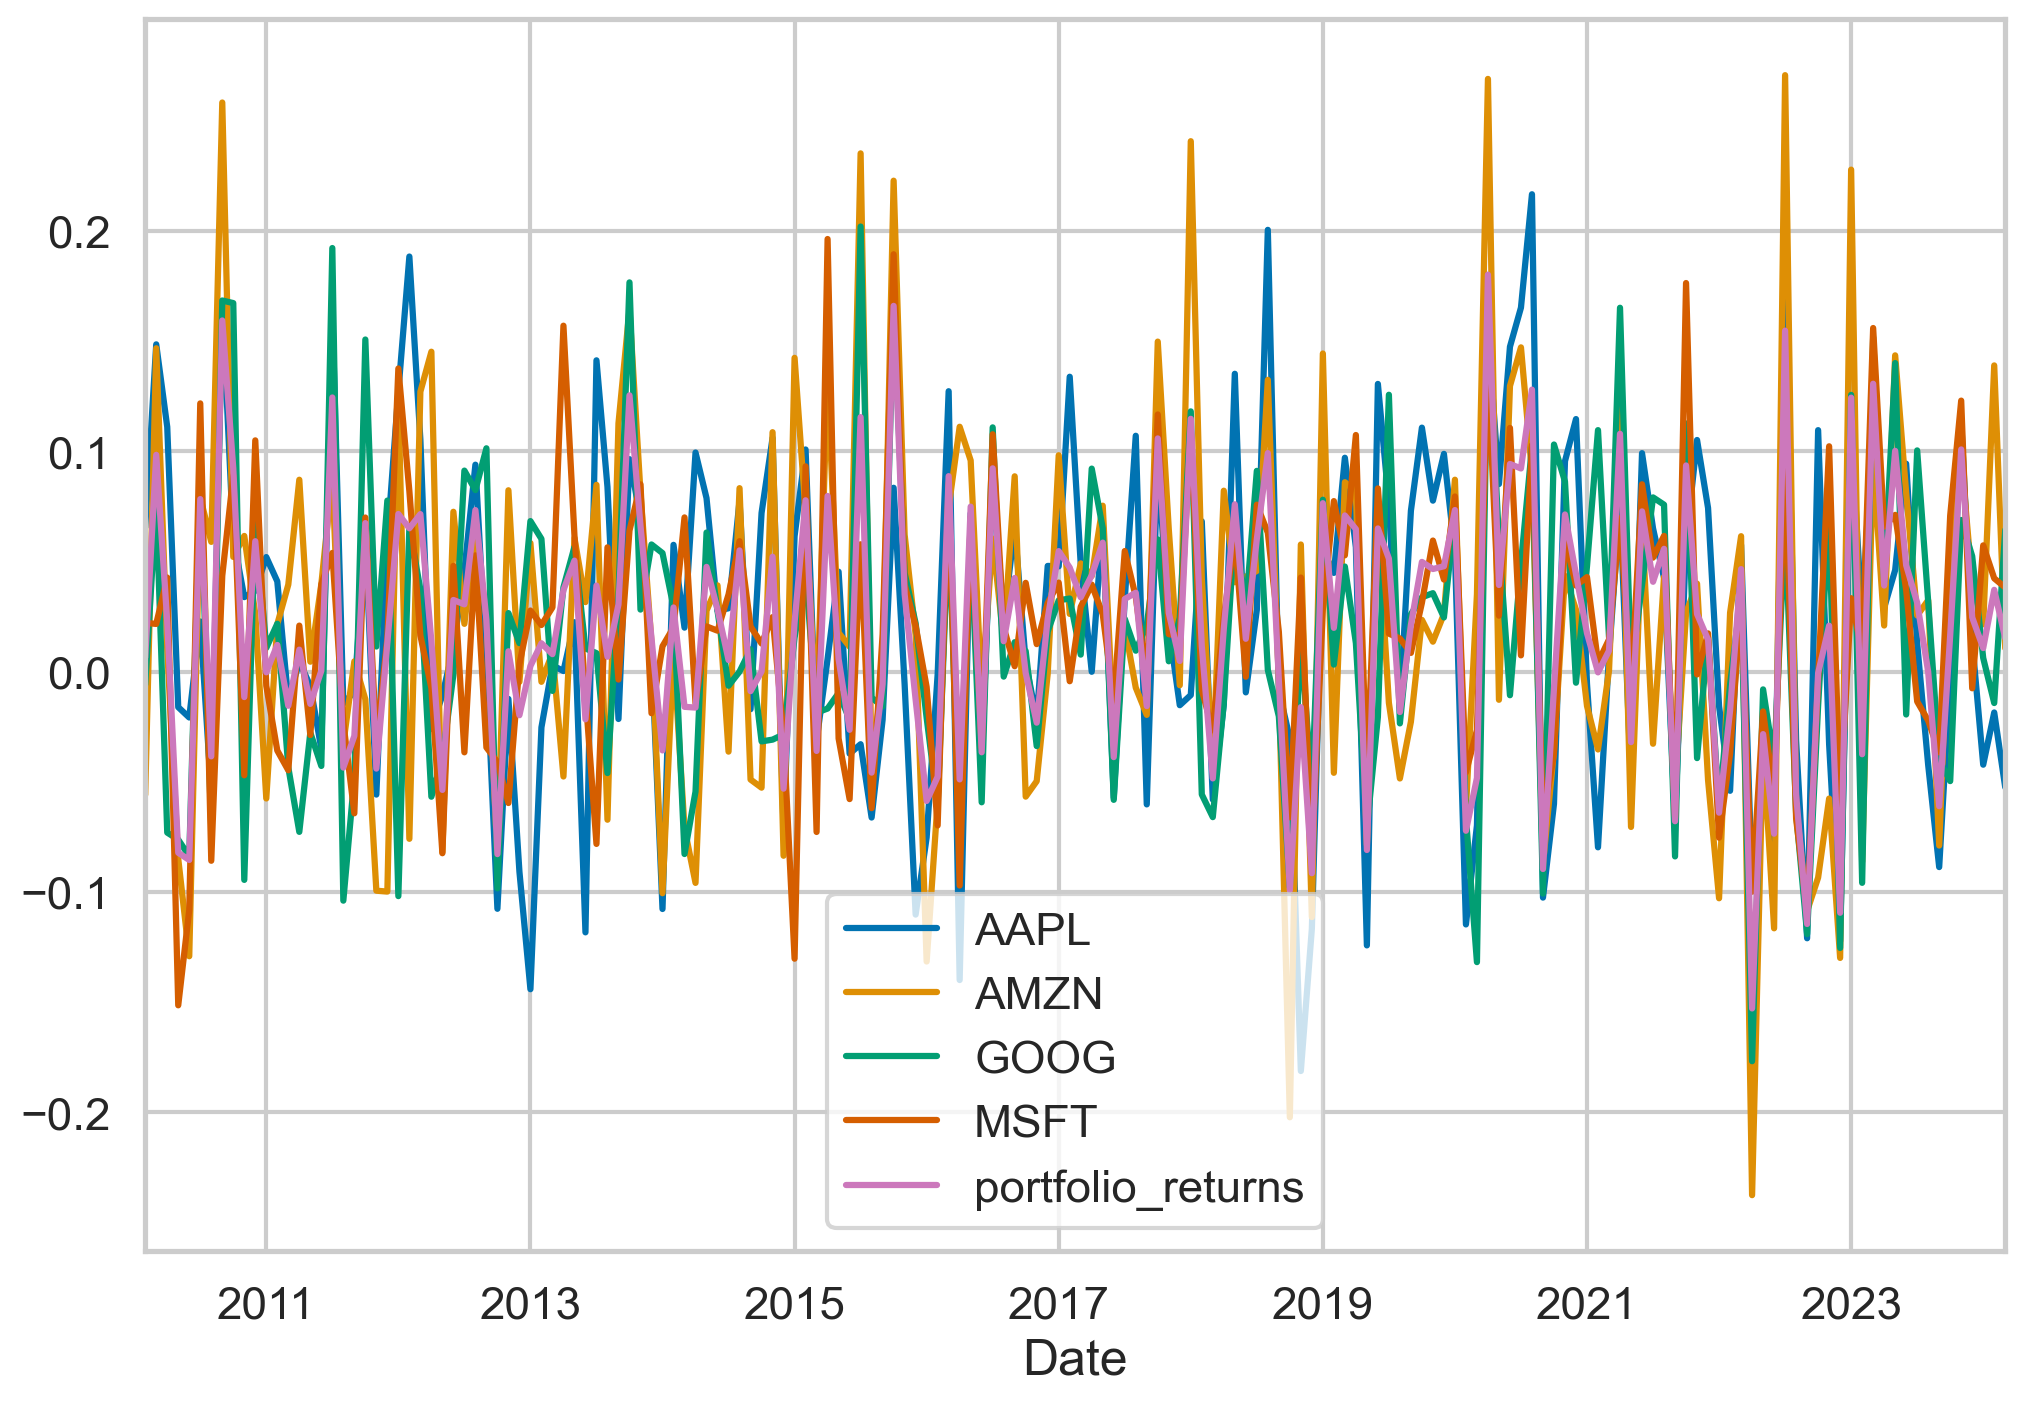

In [56]:
asset_df.plot();

In [57]:
factor_3_df = asset_df.join(factor_3_df).drop(ASSETS, axis=1)
factor_3_df.columns = ["portf_rtn", "mkt", "smb", "hml", "rf"]
factor_3_df["portf_ex_rtn"] = (
    factor_3_df["portf_rtn"] - factor_3_df["rf"]
)

In [58]:
MODEL_FORMULA = "portf_ex_rtn ~ mkt + smb + hml"
results_df = rolling_factor_model(factor_3_df, 
                                  MODEL_FORMULA, 
                                  window_size=60)

results_df.iloc[-10:]


,Intercept,mkt,smb,hml
Date,,,,
2023-06,0.006189,1.149249,-0.294071,-0.540429
2023-07,0.006239,1.147076,-0.281606,-0.537008
2023-08,0.005739,1.143223,-0.290059,-0.527049
2023-09,0.005961,1.147365,-0.299798,-0.531843
2023-10,0.006750,1.139253,-0.334364,-0.525834
2023-11,0.007426,1.140890,-0.340314,-0.524668
2023-12,0.007736,1.135329,-0.334906,-0.523897
2024-01,0.007516,1.136585,-0.286232,-0.519856
2024-02,0.008132,1.139355,-0.270810,-0.528149


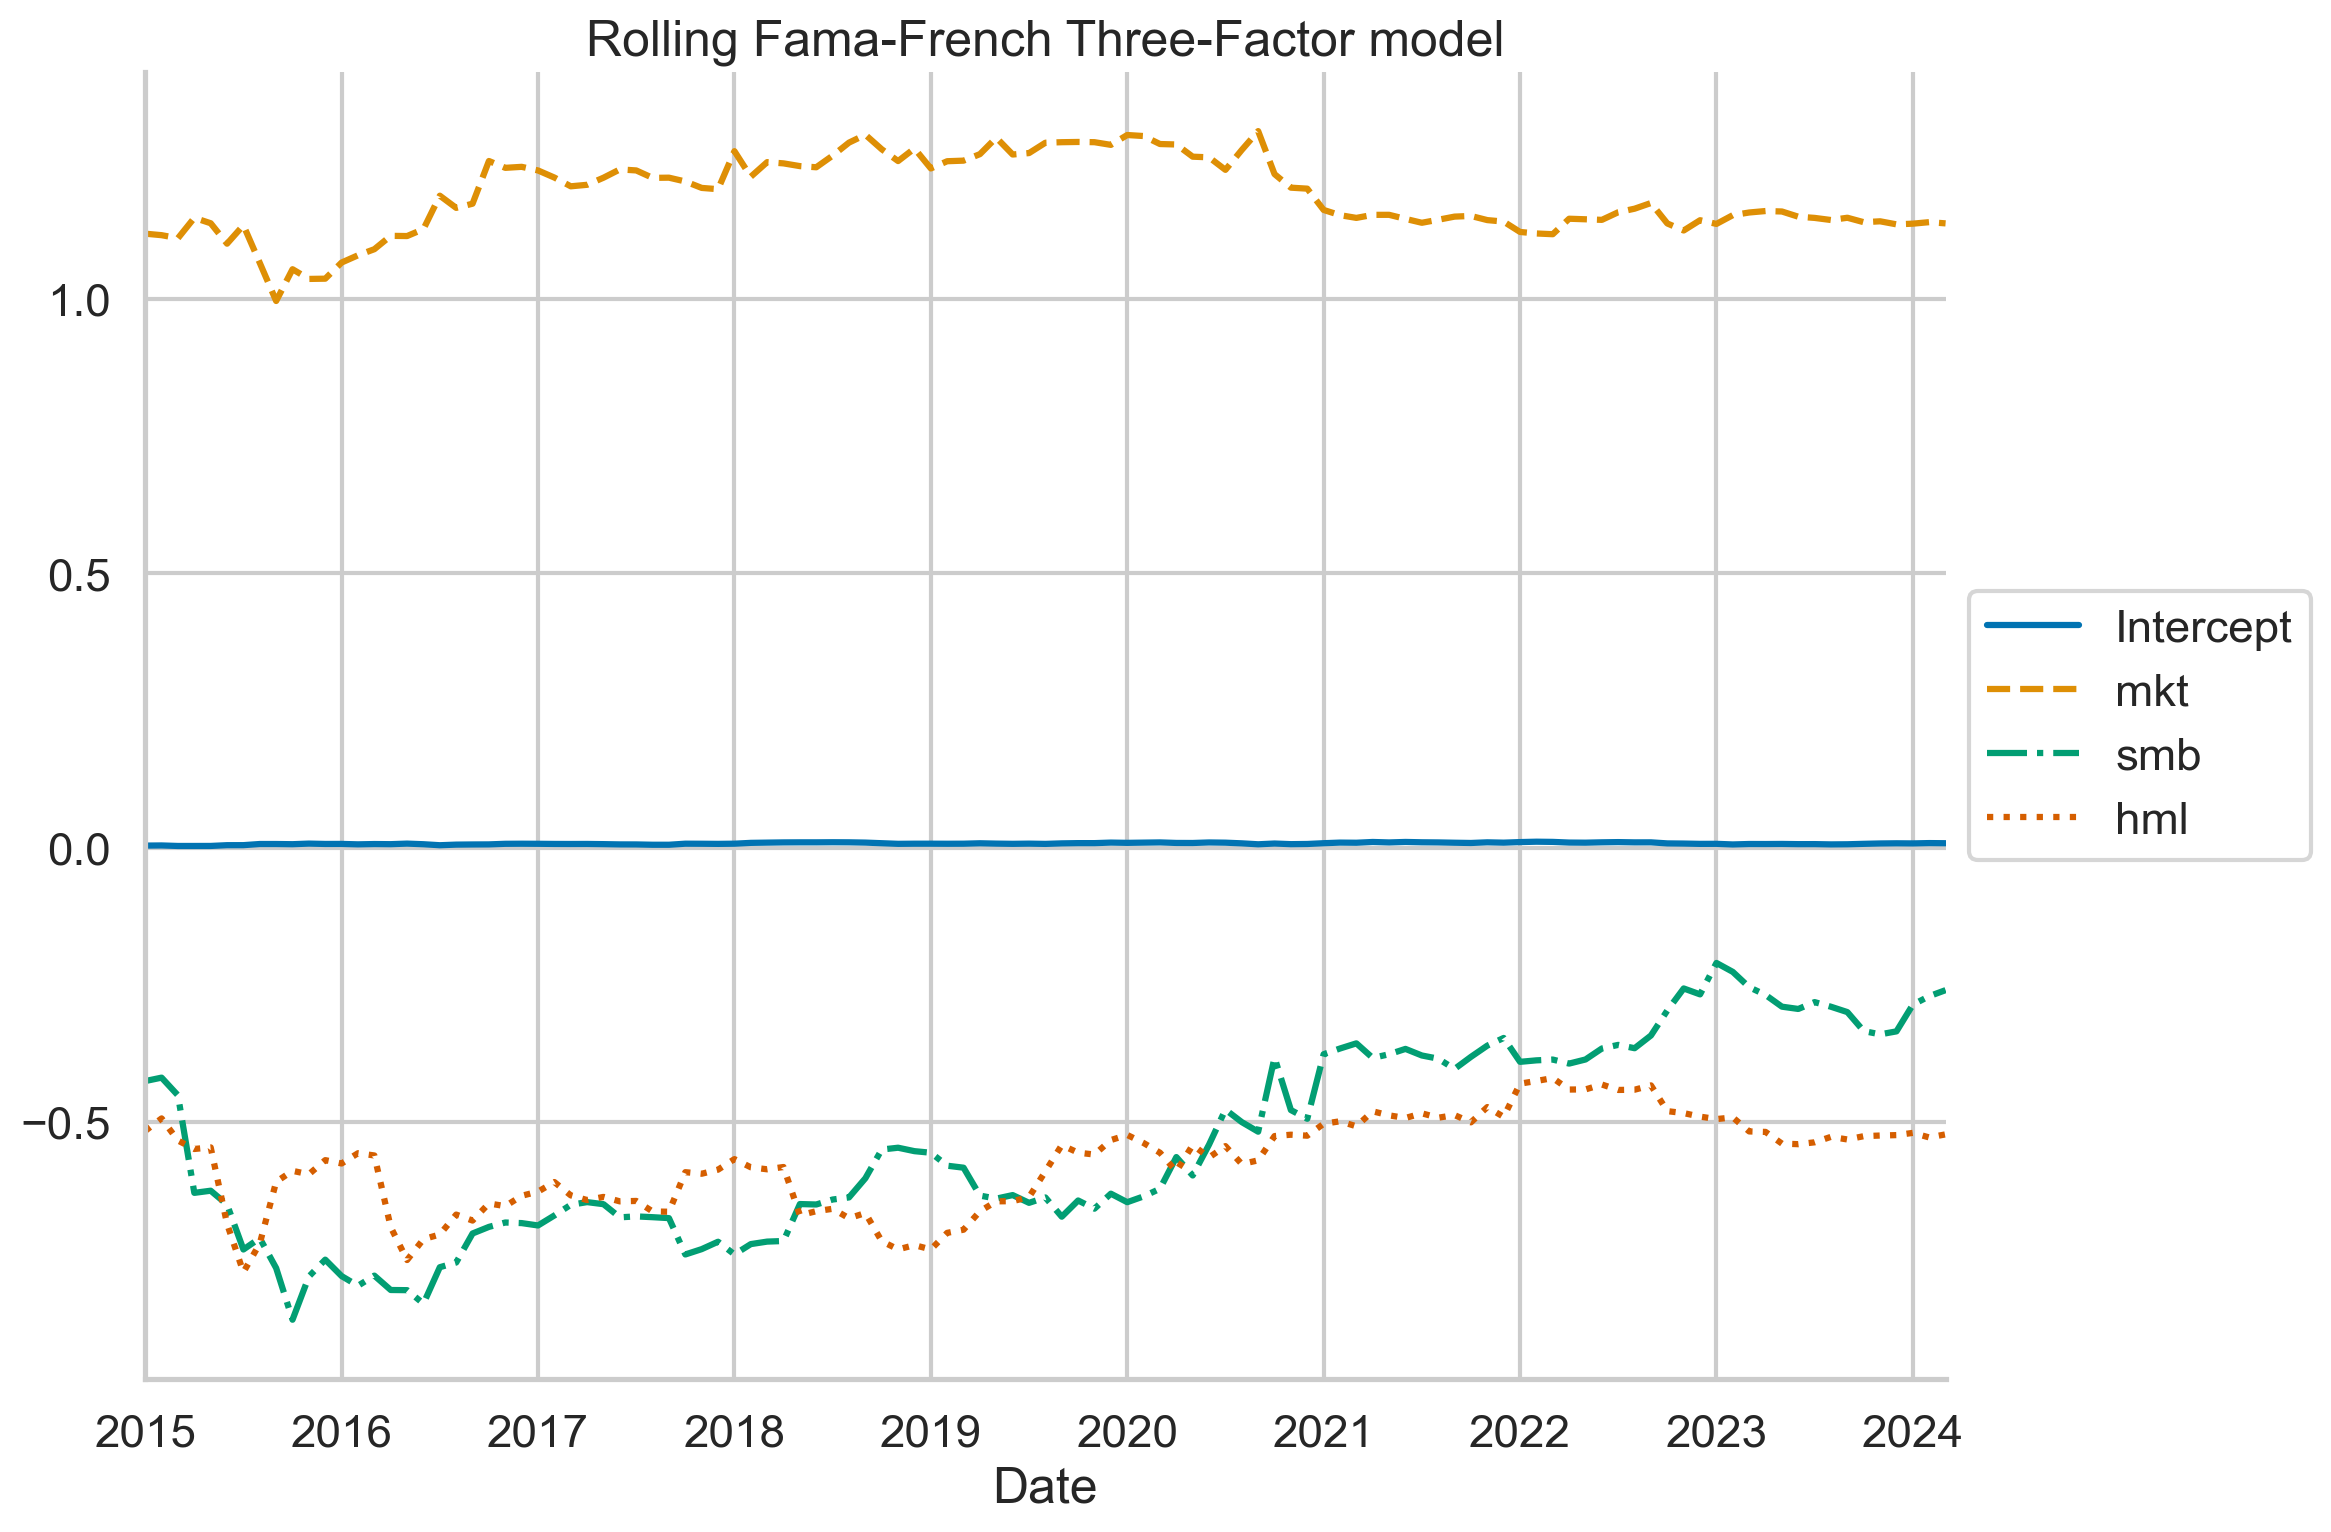

In [59]:
(
    results_df
    .plot(title = "Rolling Fama-French Three-Factor model",
          style=["-", "--", "-.", ":"])
    .legend(loc="center left",bbox_to_anchor=(1.0, 0.5))
)

sns.despine()
plt.tight_layout()

<br>

Try it yourself, please estimate the rolling 4- and 5-factor model with 5-year window.